In [77]:
import torch
from model.unet_modified import UNet
from dataset import *
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os
import numpy as np

# Plotting function
def plot_results(input_image, original_mask, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    input_image_np = extract_sagittal_view_(input_image.squeeze().cpu().numpy())
    original_mask_np = extract_sagittal_view_(original_mask.squeeze().cpu().numpy())
    predicted_mask_np = extract_sagittal_view_(predicted_mask.squeeze().cpu().numpy())
    
    # Plot original image
    axes[0].imshow(input_image_np, cmap='gray')
    axes[0].set_title('Original Image')
    
    # Plot original mask
    axes[1].imshow(original_mask_np, cmap='jet')
    axes[1].set_title('Original Mask')
    
    # Plot predicted mask
    axes[2].imshow(predicted_mask_np, cmap='jet')
    axes[2].set_title('Predicted Mask')
    
    for ax in axes:
        ax.axis('off')
    
    plt.show()

def extract_sagittal_view_(img_array):
    """
    Extract the sagittal view from a 3D numpy array.
    Compute the mean along the x-axis and return the middle slice.
    """
    image_shape = img_array.shape
    print(image_shape)
    mean_x_axis = img_array.shape[2] // 2
    sagittal_view = img_array[:, :, mean_x_axis]
    # sagittal_view = np.rot90(sagittal_view)
    # sagittal_view = np.flipud(sagittal_view)
    print(sagittal_view.shape)
    return sagittal_view
    

# Set the paths
base_path = '../inputs/'
overview_path = os.path.join(base_path, 'overview.csv')
image_path = os.path.join(base_path, 'images/')
mask_path = os.path.join(base_path, 'masks/')
sagittal_view_list = {}
mask_list = {}

predicted_images = ['24_t2', '82_t1', '82_t2', '88_t1']
original_masks = ['24_t2','82_t1', '82_t2', '88_t1']

# resampling the images and masks
resampled_images = resample_image_sitk(image_path, predicted_images, target_shape= TARGET_SHAPE, files_number=4)
resampled_masks = resample_image_sitk(mask_path, original_masks, target_shape= TARGET_SHAPE, files_number=4)

device = torch.device('cpu')
print(torch.cuda.is_available())
print("Device:",device)

def load_nii_to_tensor(path):
    image = sitk.ReadImage(path)
    image_array = sitk.GetArrayFromImage(image)
    image_array = torch.tensor(image_array, dtype=torch.float32).to(device)
    return image_array

prediction_images = [load_nii_to_tensor(image) for image in resampled_images]
original_masks = [load_nii_to_tensor(image) for image in resampled_masks]


False
Device: cpu


In [78]:
class MRIDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Ensure the images and masks are in (C, D, H, W) format, where C is the channel dimension
        image = self.images[idx]
        mask = self.masks[idx]
        if len(image.shape) == 3:  # if there is no channel dimension
            image = image.unsqueeze(0)  # Add channel dimension at position 0
        if len(mask.shape) == 3:  # if there is no channel dimension
            mask = mask.unsqueeze(0)  # Add channel dimension at position 0
        
        # Ensure the mask has the same number of channels as the output
        if mask.shape[0] != 20:
            mask = mask.repeat(20, 1, 1, 1)  # Repeat mask along the channel dimension

        return image, mask

# Assuming `images` and `masks` are lists of 3D tensors
training_dataset = MRIDataset(prediction_images, original_masks)
dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True)

Input shape: torch.Size([1, 1, 128, 128, 64])
Shape after initial conv: torch.Size([1, 64, 128, 128, 64])
Shape after down1: torch.Size([1, 128, 64, 64, 32])
Shape after down2: torch.Size([1, 256, 32, 32, 16])
Shape after down3: torch.Size([1, 512, 16, 16, 8])
Shape after down4: torch.Size([1, 512, 8, 8, 4])
Shape after up1: torch.Size([1, 256, 16, 16, 8])
Shape after up2: torch.Size([1, 128, 32, 32, 16])
Shape after up3: torch.Size([1, 64, 64, 64, 32])
Shape after up4: torch.Size([1, 64, 128, 128, 64])
Output shape: torch.Size([1, 20, 128, 128, 64])
(128, 128, 64)
(128, 128)
(128, 128, 64)
(128, 128)
(128, 128, 64)
(128, 128)


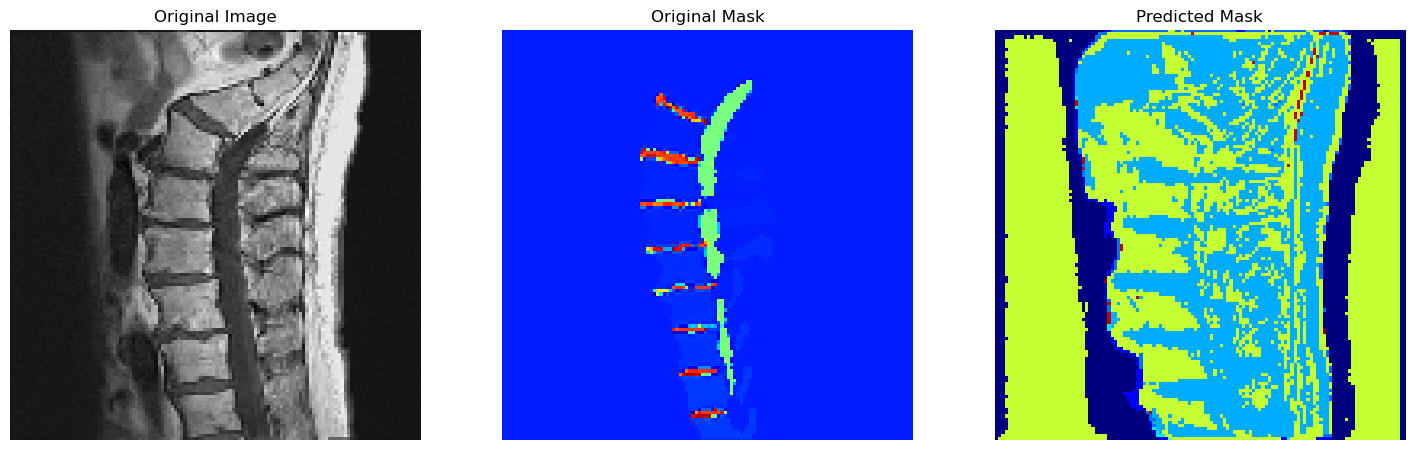

Input shape: torch.Size([1, 128, 128, 64])
Output shape: torch.Size([1, 20, 128, 128, 64])
Segmentation shape: torch.Size([1, 128, 128, 64])
Segmentation (numpy) shape: (1, 128, 128, 64)
Input shape: torch.Size([1, 1, 128, 128, 64])
Shape after initial conv: torch.Size([1, 64, 128, 128, 64])
Shape after down1: torch.Size([1, 128, 64, 64, 32])
Shape after down2: torch.Size([1, 256, 32, 32, 16])
Shape after down3: torch.Size([1, 512, 16, 16, 8])
Shape after down4: torch.Size([1, 512, 8, 8, 4])
Shape after up1: torch.Size([1, 256, 16, 16, 8])
Shape after up2: torch.Size([1, 128, 32, 32, 16])
Shape after up3: torch.Size([1, 64, 64, 64, 32])
Shape after up4: torch.Size([1, 64, 128, 128, 64])
Output shape: torch.Size([1, 20, 128, 128, 64])
(128, 128, 64)
(128, 128)
(128, 128, 64)
(128, 128)
(128, 128, 64)
(128, 128)


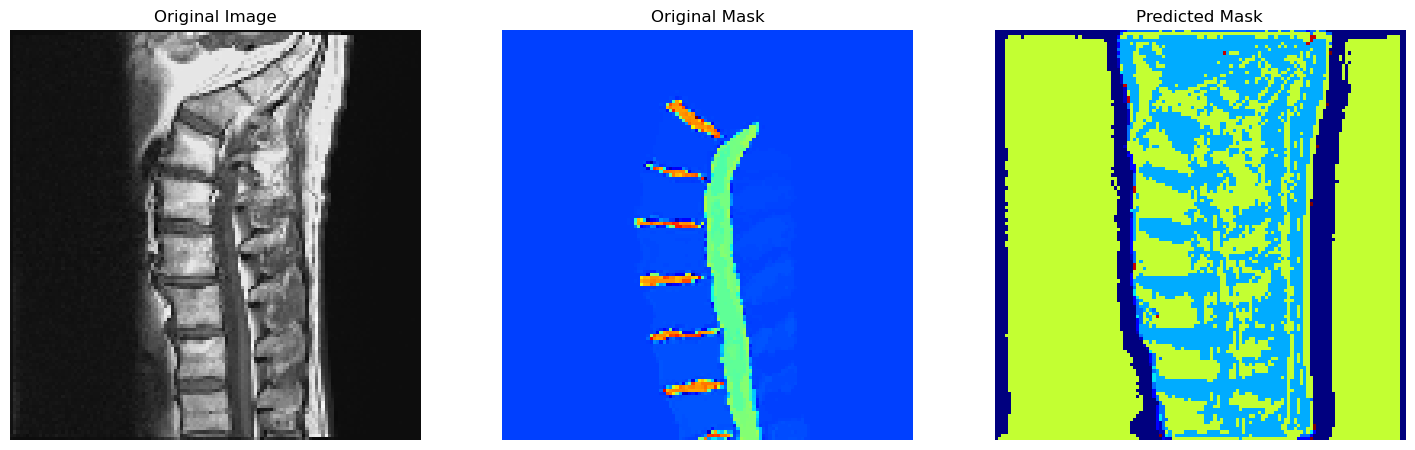

Input shape: torch.Size([1, 128, 128, 64])
Output shape: torch.Size([1, 20, 128, 128, 64])
Segmentation shape: torch.Size([1, 128, 128, 64])
Segmentation (numpy) shape: (1, 128, 128, 64)
Input shape: torch.Size([1, 1, 128, 128, 64])
Shape after initial conv: torch.Size([1, 64, 128, 128, 64])
Shape after down1: torch.Size([1, 128, 64, 64, 32])
Shape after down2: torch.Size([1, 256, 32, 32, 16])
Shape after down3: torch.Size([1, 512, 16, 16, 8])
Shape after down4: torch.Size([1, 512, 8, 8, 4])
Shape after up1: torch.Size([1, 256, 16, 16, 8])
Shape after up2: torch.Size([1, 128, 32, 32, 16])
Shape after up3: torch.Size([1, 64, 64, 64, 32])
Shape after up4: torch.Size([1, 64, 128, 128, 64])
Output shape: torch.Size([1, 20, 128, 128, 64])
(128, 128, 64)
(128, 128)
(128, 128, 64)
(128, 128)
(128, 128, 64)
(128, 128)


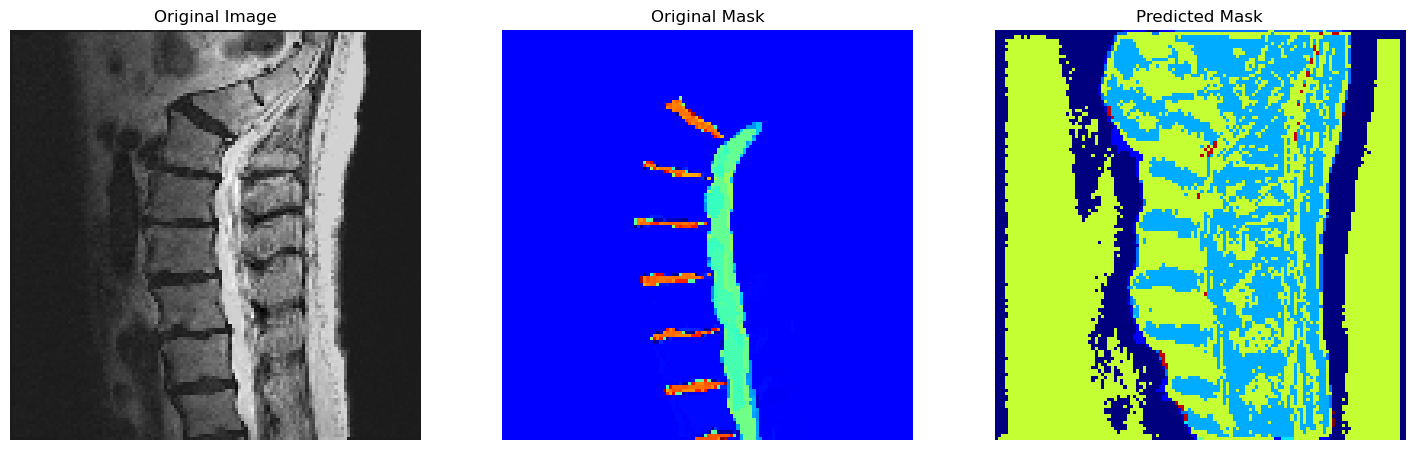

Input shape: torch.Size([1, 128, 128, 64])
Output shape: torch.Size([1, 20, 128, 128, 64])
Segmentation shape: torch.Size([1, 128, 128, 64])
Segmentation (numpy) shape: (1, 128, 128, 64)
Input shape: torch.Size([1, 1, 128, 128, 64])
Shape after initial conv: torch.Size([1, 64, 128, 128, 64])
Shape after down1: torch.Size([1, 128, 64, 64, 32])
Shape after down2: torch.Size([1, 256, 32, 32, 16])
Shape after down3: torch.Size([1, 512, 16, 16, 8])
Shape after down4: torch.Size([1, 512, 8, 8, 4])
Shape after up1: torch.Size([1, 256, 16, 16, 8])
Shape after up2: torch.Size([1, 128, 32, 32, 16])
Shape after up3: torch.Size([1, 64, 64, 64, 32])
Shape after up4: torch.Size([1, 64, 128, 128, 64])
Output shape: torch.Size([1, 20, 128, 128, 64])
(128, 128, 64)
(128, 128)
(128, 128, 64)
(128, 128)
(128, 128, 64)
(128, 128)


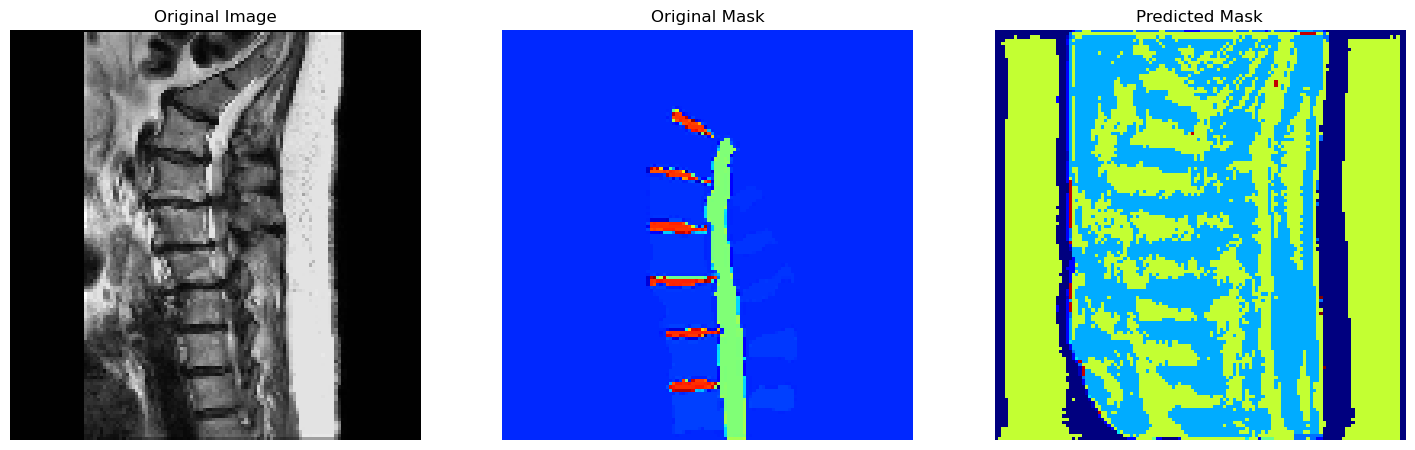

Input shape: torch.Size([1, 128, 128, 64])
Output shape: torch.Size([1, 20, 128, 128, 64])
Segmentation shape: torch.Size([1, 128, 128, 64])
Segmentation (numpy) shape: (1, 128, 128, 64)


In [79]:
model = UNet(n_channels=1, n_classes=20)
# Load the entire checkpoint
checkpoint = torch.load("model3.pth", map_location=torch.device('cpu'))

# Extract the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# preprocess the input image
def preprocess_image(image):
    if len(image.shape) == 3: 
        image = image.unsqueeze(0)  # Add channel dimension at position 0
    return image

# post-process the output
def postprocess_output(output):
    # take the argmax across the channel dimension
    return torch.argmax(output, dim=1)

for i, (img, mask) in enumerate(dataloader):
    input_image = img[0]
    original_mask = mask[0]
    
    input_image = preprocess_image(input_image)
    original_mask = preprocess_image(original_mask)

    with torch.no_grad():
        output = model(input_image.unsqueeze(0))  # Add batch dimension
        predicted_mask = postprocess_output(output)

    # Plot the results
    plot_results(input_image, original_masks[i], predicted_mask)

    # Print the shapes to verify
    print(f"Input shape: {input_image.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Segmentation shape: {predicted_mask.shape}")

    # If you need to convert the segmentation to numpy for further processing
    segmentation_numpy = predicted_mask.cpu().numpy()
    print(f"Segmentation (numpy) shape: {segmentation_numpy.shape}")